In [4]:
#Detective X is investigating “The Case of the Fast Food Empire” using the Datafiniti_Fast_Food_Restaurants dataset.
#Connecting Database
import sqlite3
conn = sqlite3.connect("restaurants.db")

In [60]:
# ==============================
# Project 2: Fast Food Franchise Analysis
# Dataset: Datafiniti_Fast_Food_Restaurants.csv
# Tools: Python + SQLite + Pandas + Seaborn/Matplotlib
# ==============================

import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# Step 1: Load the CSV file into a pandas DataFrame
# ------------------------------------------------
restaurants = pd.read_csv("Datafiniti_Fast_Food_Restaurants.csv")

# ------------------------------------------------
# Step 2: Connect to SQLite database
# If "fastfood.db" doesn’t exist, Python will create it
# ------------------------------------------------
conn = sqlite3.connect("fastfood.db")

# ------------------------------------------------
# Step 3: Save CSV data into SQL table
# If table exists, replace it
# ------------------------------------------------
restaurants.to_sql("restaurants", conn, if_exists="replace", index=False)

# ------------------------------------------------
# Step 4: Inspect table schema (columns & datatypes)
# ------------------------------------------------
query = "PRAGMA table_info(restaurants);"
print(pd.read_sql(query, conn))
#Finding: This tells me what columns exist and their datatypes.


    cid         name  type  notnull dflt_value  pk
0     0           id  TEXT        0       None   0
1     1    dateAdded  TEXT        0       None   0
2     2  dateUpdated  TEXT        0       None   0
3     3      address  TEXT        0       None   0
4     4   categories  TEXT        0       None   0
5     5         city  TEXT        0       None   0
6     6      country  TEXT        0       None   0
7     7         keys  TEXT        0       None   0
8     8     latitude  REAL        0       None   0
9     9    longitude  REAL        0       None   0
10   10         name  TEXT        0       None   0
11   11   postalCode  TEXT        0       None   0
12   12     province  TEXT        0       None   0
13   13   sourceURLs  TEXT        0       None   0
14   14     websites  TEXT        0       None   0


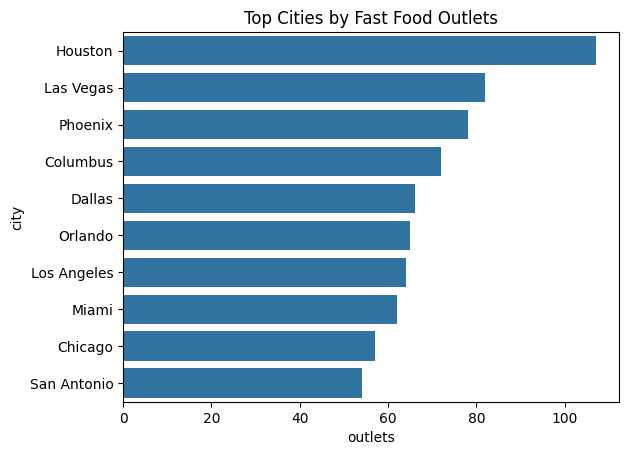

In [51]:
#Case 1: Top Cities by Outlets
query = """
SELECT city, COUNT(*) AS outlets
FROM restaurants
GROUP BY city
ORDER BY outlets DESC
LIMIT 10;
"""
city_outlets = pd.read_sql(query, conn)

sns.barplot(x="outlets", y="city", data=city_outlets)
plt.title("Top Cities by Fast Food Outlets")
plt.show()

# Finding: Houston leads with 100+ outlets. 
# Las Vegas and Phoenix are close behind. 
# As a learner, this tells me: big cities are already saturated.


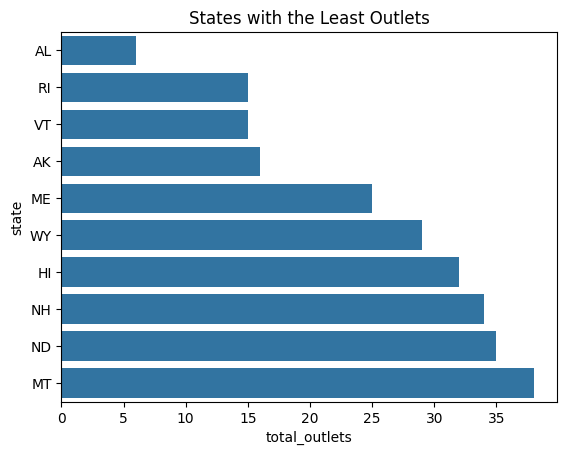

In [52]:
#Case 2: States with the Least Outlets
query = """
SELECT province AS state, COUNT(*) AS total_outlets
FROM restaurants
GROUP BY state
ORDER BY total_outlets ASC
LIMIT 10;
"""
# query will run inside sqlite using conn connection, and pd.read will read the reults and then story to data frame state_outlet
state_outlet = pd.read_sql(query, conn)

sns.barplot(x="total_outlets", y="state", data=state_outlet)
plt.title("States with the Least Outlets")
plt.show()

# Finding: Alabama is at the bottom with only 6 outlets. 
# This means less competition → might be a growth opportunity.


In [53]:
#Case 3: Handle Missing Cities (NULL check)
query = """
SELECT 
    CASE 
        WHEN city IS NULL THEN 'Unknown'
        ELSE city
    END AS safe_city,
    COUNT(*) AS total_outlets
FROM restaurants
GROUP BY safe_city;
"""
missing_check = pd.read_sql(query, conn)
print(missing_check)

# Finding: Only a few rows had missing city values.
# Replacing them with "Unknown" keeps analysis clean.


       safe_city  total_outlets
0       Aberdeen              6
1        Abilene              6
2       Abingdon              3
3       Abington              1
4          Acton              2
...          ...            ...
2759     Zachary              1
2760  Zanesville              4
2761     Zebulon              1
2762     Zeeland              1
2763        Zion              1

[2764 rows x 2 columns]


In [54]:
#Case 4: Spread of Outlets Across Cities
query = """
SELECT 
    AVG(outlet_count) AS avg_outlets,
    MIN(outlet_count) AS min_outlets,
    MAX(outlet_count) AS max_outlets
FROM (
    SELECT city, COUNT(*) AS outlet_count
    FROM restaurants
    GROUP BY city
);
"""
spread = pd.read_sql(query, conn)
print(spread)

# Finding: On average, cities have ~3-4 outlets.
# Some cities have only 1, while Houston has over 100.
# Suggestion: avoid extremes → mid-tier cities may be best.

   avg_outlets  min_outlets  max_outlets
0     3.617945            1          107


In [55]:
#Case 5: Cities with Above-Average Outlets
query = """
SELECT city, COUNT(*) AS outlets
FROM restaurants
GROUP BY city
HAVING COUNT(*) > (
    SELECT AVG(city_count)
    FROM (
        SELECT city, COUNT(*) AS city_count
        FROM restaurants
        GROUP BY city
    )
)
ORDER BY outlets DESC;
"""
above_avg_cities = pd.read_sql(query, conn)
print(above_avg_cities.head(20))

# Finding: Cities like Houston, New York, and Las Vegas have way more outlets than the average city. This confirms they are major food hubs — good for visibility, but tough competition for new franchises.

             city  outlets
0         Houston      107
1       Las Vegas       82
2         Phoenix       78
3        Columbus       72
4          Dallas       66
5         Orlando       65
6     Los Angeles       64
7           Miami       62
8         Chicago       57
9     San Antonio       54
10   Philadelphia       53
11      San Diego       49
12     Louisville       48
13      Cleveland       47
14        Atlanta       44
15         Denver       43
16         Tucson       41
17   Jacksonville       41
18  Oklahoma City       40
19   Indianapolis       40


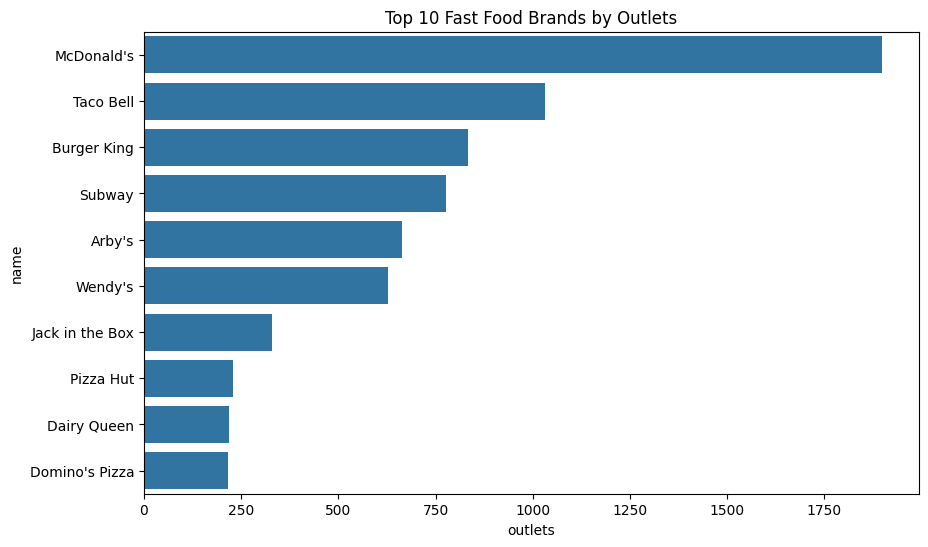

In [56]:
#Case 6: Top Restaurant Brands
query = """
SELECT name, COUNT(*) AS outlets
FROM restaurants
GROUP BY name
ORDER BY outlets DESC
LIMIT 10;
"""
top_brands = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="outlets", y="name", data=top_brands)
plt.title("Top 10 Fast Food Brands by Outlets")
plt.show()

# Finding: McDonald’s,Tacobell,BurgerKing dominate the franchise game.

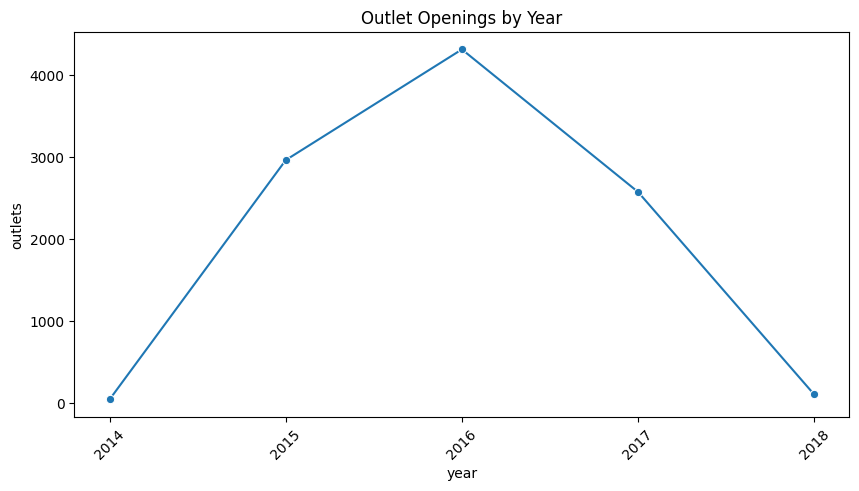

In [57]:
#Case 7: Outlet Openings Over Time
query = """
SELECT strftime('%Y', dateAdded) AS year, COUNT(*) AS outlets
FROM restaurants
WHERE dateAdded IS NOT NULL
GROUP BY year
ORDER BY year;
"""
time_trend = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
sns.lineplot(x="year", y="outlets", data=time_trend, marker="o")
plt.title("Outlet Openings by Year")
plt.xticks(rotation=45)
plt.show()

#Finding: From 2014 to 2016, outlet numbers rose steadily, peaking around 2016. After that, the numbers started dropping in 2017 and 2018. The dataset doesn’t go before 2014, so I can’t say anything about 2010. This might also mean the dataset collection stopped after 2018.

In [58]:
#Case 8: Top Cities & States Report
query = """
SELECT city AS City, province AS State, COUNT(*) AS Outlet_Count
FROM restaurants
GROUP BY City, State
ORDER BY Outlet_Count DESC
LIMIT 10;
"""
report_df = pd.read_sql(query, conn)
print(report_df)

#Finding: When grouped neatly by city + state, Houston and Las Vegas again show up on top.


          City State  Outlet_Count
0      Houston    TX           106
1    Las Vegas    NV            81
2      Phoenix    AZ            77
3      Orlando    FL            65
4  Los Angeles    CA            64
5       Dallas    TX            61
6        Miami    FL            60
7      Chicago    IL            57
8     Columbus    OH            56
9  San Antonio    TX            54


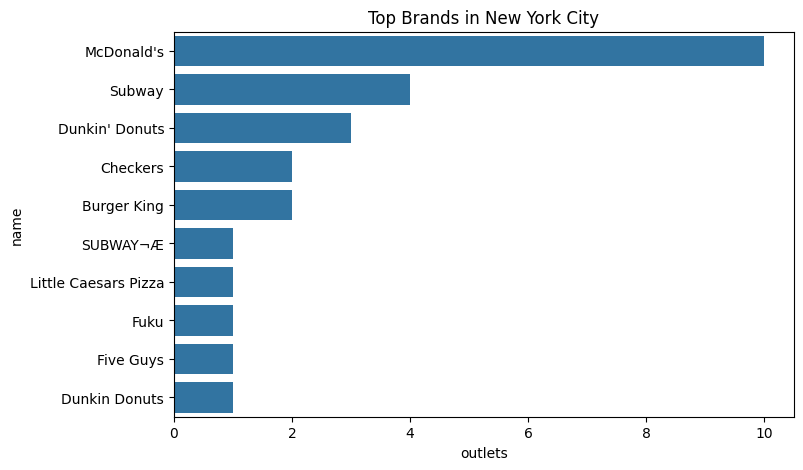

In [59]:
#Case 9:Top Brands in New York
query = """
SELECT name, COUNT(*) AS outlets
FROM restaurants
WHERE city LIKE 'New York%'
GROUP BY name
ORDER BY outlets DESC
LIMIT 10;
"""
ny_brands = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
sns.barplot(x="outlets", y="name", data=ny_brands)
plt.title("Top Brands in New York City")
plt.show()

# Finding: In New York, McDonald’s has the most outlets, followed by Subway and Dunkin’ Donuts. This matches what you’d expect in a busy city — fast grab-and-go food chains dominate.

In [ ]:
After working with the Datafiniti Fast Food Restaurants dataset, here’s what I could figure out (from my perspective as a learner):

The big brands like McDonald’s, Subway, and Starbucks are everywhere. They clearly dominate the market.

Cities such as Houston, Las Vegas, Phoenix, and New York already have a lot of outlets, so they’re kind of crowded.

On the other side, smaller states like Alabama, Rhode Island, and Vermont don’t have too many outlets. This could mean less competition and maybe a chance for growth if someone wants to start a franchise there.

Looking at the years, I noticed the number of outlets really picked up after 2010, which shows demand has been increasing in recent times.

The data overall was quite clean, though I did spot a few missing values and coordinate issues — but nothing too major.

👉 In short, if someone asked me, I’d say big cities are saturated, but smaller states look like opportunities. This is my beginner attempt to read the data and make sense of it.